In [1]:
from sklearn.manifold import TSNE
import tensorflow as tf
import numpy as np
import pywt
import matplotlib.pyplot as plt
from vae import VariationalAutoencoder, pre_process, filter_func, _parse_input, test_plot
from matplotlib.gridspec import GridSpec


def pre_process(batch, preproc='', wavelet='db1'):
    """ Handles pre-processing of input data, using DWT or DFT
    Normalises data to fit into [0, 1] range
    """
    if preproc == 'DWT':
        wt = pywt.Wavelet(wavelet)
        batch = pywt.wavedec(batch, wt, axis=1, level=6)
        batch = np.hstack(batch)[:, :time_steps]
        batch = np.square(batch)
    elif preproc == 'DFT':
        batch = np.absolute(np.fft.fft(batch, axis=1))
    elif preproc == '':
        batch = np.square(batch)
    else:
        print('invalid preproc')
        batch = np.square(batch)
    batch = np.divide(batch, np.amax(batch, axis=1)[:, None]+1e-10)
    return batch


def _parse_input(serialised_input):
    """ Parse serialised input into labelled dataset with NSynth features """
    parsed_output = tf.parse_single_example(serialised_input, nsynth_feature)
    return parsed_output


time_steps = 16000 * 4
wavelet = 'db1'
nsynth_feature = {
    'note': tf.FixedLenFeature([], tf.int64),
    'note_str': tf.FixedLenFeature([], tf.string),
    'instrument': tf.FixedLenFeature([], tf.int64),
    'instrument_str': tf.FixedLenFeature([], tf.string),
    'pitch': tf.FixedLenFeature([], tf.int64),
    'velocity': tf.FixedLenFeature([], tf.int64),
    'sample_rate': tf.FixedLenFeature([], tf.int64),
    'audio': tf.FixedLenFeature([time_steps], tf.float32),
    'qualities': tf.FixedLenFeature([10], tf.int64),
    'qualities_str': tf.VarLenFeature(tf.string),
    'instrument_family': tf.FixedLenFeature([], tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], tf.string),
    'instrument_source': tf.FixedLenFeature([], tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], tf.string),
}

sub_samp = 2
div = 8
time_steps = time_steps // sub_samp // div
batch_size = 50
n_samples = 289205

# Define number of nodes in each layer
vae_architecture = dict(
    n_hidden_recog_1=2000,
    n_hidden_recog_2=1000,
    n_hidden_gener_1=1000,
    n_hidden_gener_2=2000,
    n_input=time_steps,
    n_output=time_steps,
    n_z=64
)

vae = VariationalAutoencoder(vae_architecture, batch_size=batch_size, restore='DFT')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tmp/modelDFT.ckpt


In [2]:
nsynth_valid_2 = tf.data.TFRecordDataset("nsynth-valid.tfrecord")
nsynth_valid_1 = nsynth_valid_2.map(_parse_input)

nsynth_valid = nsynth_valid_1.filter(filter_func).batch(1000)
iterator = nsynth_valid.make_one_shot_iterator().get_next()
valid_dict = vae.sess.run(iterator)



In [7]:
from sklearn.manifold import TSNE

preproc = 'DWT'
valid_audio = valid_dict['audio'][:, :16000*4//div:sub_samp]
valid_procc = pre_process(valid_audio, preproc)
valid_latent = np.array(vae.encode(valid_procc))
valid_embed = TSNE(n_components=2).fit_transform(valid_latent)


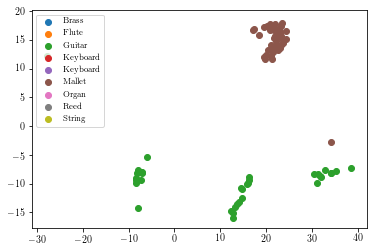

In [8]:
f, ax1 = plt.subplots()
instrument_family_str = ['Bass', 'Brass', 'Flute', 'Guitar', 'Keyboard', 
               'Keyboard', 'Mallet', 'Organ', 'Reed', 'String', 'Synth_lead', 'Vocal']
for i in range(1,10):
    valid_iter = valid_embed[valid_dict['instrument_family']==i]
    ax1.scatter(valid_iter[:,0],valid_iter[:,1], label = instrument_family_str[i])
ax1.legend(fontsize='small', loc='upper left')



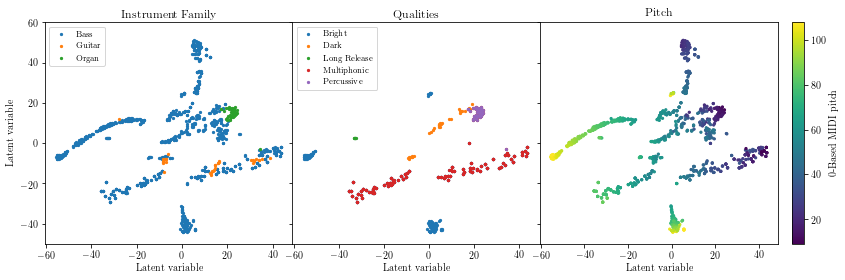

In [15]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1, 1.2]})

instrument_family_str = ['Bass', 'Brass', 'Flute', 'Guitar', 'Keyboard', 'Mallet', 'Organ', 'Reed', 'String', 'Synth lead', 'Vocal']
for i in range(0,10):
    valid_iter = valid_embed[valid_dict['instrument_family']==i]
    if len(valid_iter)!=0:
        ax0.scatter(valid_iter[:,0],valid_iter[:,1], label = instrument_family_str[i], s=5)
ax0.legend(fontsize='small', loc='upper left')

quality_str = ['Bright', 'Dark', 'Fast Decat', 'Long Release', 'Multiphonic', 
               'Nonlinear Envelope', 'Percussive', 'Reverb', 'Tempo-eynched']
for i in range(9):
    if i !=2:
        valid_iter = valid_embed[valid_dict['qualities'][:,i]==1]
        if len(valid_iter) != 0:
            ax1.scatter(valid_iter[:,0],valid_iter[:,1], label = quality_str[i], s=5)
cm = plt.cm.get_cmap('viridis', 256)
sc = ax2.scatter(valid_embed[:,0],valid_embed[:,1], c=valid_dict['pitch'], cmap=cm, s=5)
f.colorbar(sc, label="0-Based MIDI pitch")

ax1.legend(fontsize='small', loc='upper left')
ax1.set_yticklabels([])
ax2.set_yticklabels([])

ax0.set_ylim([-50, 60])
ax1.set_ylim([-50, 60])
ax2.set_ylim([-50, 60])

ax0.set_title('Instrument Family')
ax1.set_title('Qualities')
ax2.set_title('Pitch')
ax0.set_ylabel('Latent variable')
ax2.set_xlabel('Latent variable')
ax1.set_xlabel('Latent variable')
ax0.set_xlabel('Latent variable')
plt.tight_layout()

f.subplots_adjust(wspace=0, hspace=0)

f.savefig('latent{}.pdf'.format(preproc))

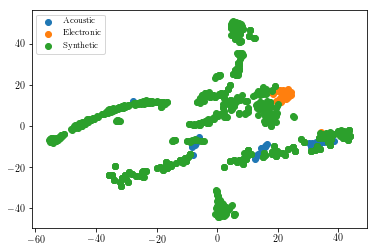

In [10]:

f, ax1 = plt.subplots()
instrument_family_str = ['Acoustic', 'Electronic', 'Synthetic']
for i in range(3):
    valid_iter = valid_embed[valid_dict['instrument_source']==i]
    ax1.scatter(valid_iter[:,0],valid_iter[:,1], label = instrument_family_str[i])
ax1.legend(fontsize='small', loc='upper left')
